# 预处理

## 算法库导入

In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, Reshape, Dropout
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.losses import mse

from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import to_categorical,plot_model

import keras.backend as K
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

tf.compat.v1.disable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


## 加载数据

In [2]:
index80 = 1 # i80道路

Intrain80 = np.load('data/EnIntrain%s.npy' % index80)
Outtrain80 = np.load('data/EnOuttrain%s.npy' % index80)

InLtrain80 = np.load('data/EnIntrain%s.npy' % index80)
OutLtrain80 = np.load('data/EnOutLtrain%s.npy' % index80)

Intest80 = np.load('data/EnIntest%s.npy' % index80)
Outtest80 = np.load('data/EnOuttest%s.npy' % index80)

InLtest80 = np.load('data/EnIntest%s.npy' % index80)
OutLtest80 = np.load('data/EnOutLtest%s.npy' % index80)

print(Intrain80.shape, OutLtrain80.shape, Outtest80.shape, OutLtest80.shape)

index101 = 2 # us101道路

Intrain101 = np.load('data/EnIntrain%s.npy' % index101)
Outtrain101 = np.load('data/EnOuttrain%s.npy' % index101)

InLtrain101 = np.load('data/EnIntrain%s.npy' % index101)
OutLtrain101 = np.load('data/EnOutLtrain%s.npy' % index101)

Intest101 = np.load('data/EnIntest%s.npy' % index101)
Outtest101 = np.load('data/EnOuttest%s.npy' % index101)

InLtest101 = np.load('data/EnIntest%s.npy' % index101)
OutLtest101 = np.load('data/EnOutLtest%s.npy' % index101)

print(Intrain101.shape, OutLtrain101.shape,
      Outtest101.shape, OutLtest101.shape)

# 数据混合，可能不满足独立同分布要求
Intrain = np.concatenate((Intrain80,Intrain101),axis=0)
Outtrain = np.concatenate((Outtrain80,Outtrain101),axis=0)

InLtrain = np.concatenate((InLtrain80,InLtrain101),axis=0)
OutLtrain = np.concatenate((OutLtrain80,OutLtrain101),axis=0)

Intest = np.concatenate((Intest80,Intest101),axis=0)
Outtest = np.concatenate((Outtest80,Outtest101),axis=0)

InLtest = np.concatenate((InLtest80,InLtest101),axis=0)
OutLtest = np.concatenate((OutLtest80,OutLtest101),axis=0)

print(Intrain.shape, OutLtrain.shape, Outtest.shape, OutLtest.shape)

(3086, 10, 2) (3086, 3) (1325, 10, 2) (1325, 3)
(2445, 10, 2) (2445, 3) (1047, 10, 2) (1047, 3)
(5531, 10, 2) (5531, 3) (2372, 10, 2) (2372, 3)


# 基于LSTM的Seq2Seq模型构建

## 双LSTM

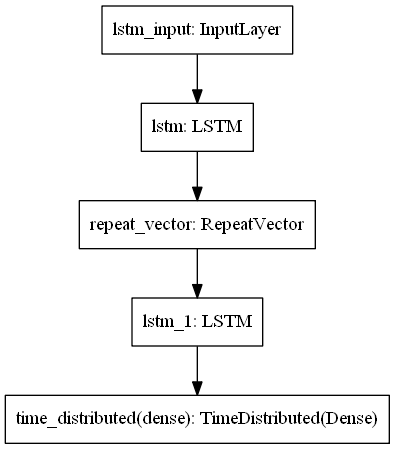

In [8]:
model = Sequential()

model.add(LSTM(72, dropout=0.1,input_shape=(Intrain.shape[1], Intrain.shape[2])))

model.add(RepeatVector(Intrain.shape[1]))

model.add(LSTM(72, return_sequences=True,dropout=0.1))

model.add(TimeDistributed(Dense(Outtrain.shape[2], activation='relu')))

model.compile(loss='mean_absolute_percentage_error',
              optimizer='adam')

# print(model.summary())
plot_model(model)

In [9]:
# fit LSTM

# 基本参数
batch_size = 60
epochs = 25
History = model.fit(Intrain, Outtrain, epochs=epochs,
                    batch_size=batch_size)

Train on 5531 samples
Epoch 1/25
5531/5531 [==============================] - 2s 312us/sample - loss: 35.7135
Epoch 2/25
5531/5531 [==============================] - 1s 263us/sample - loss: 17.8676
Epoch 3/25
5531/5531 [==============================] - 1s 245us/sample - loss: 16.2227
Epoch 4/25
5531/5531 [==============================] - 1s 244us/sample - loss: 15.2309
Epoch 5/25
5531/5531 [==============================] - 1s 245us/sample - loss: 14.8901
Epoch 6/25
5531/5531 [==============================] - 1s 253us/sample - loss: 14.7000
Epoch 7/25
5531/5531 [==============================] - 1s 253us/sample - loss: 14.3858
Epoch 8/25
5531/5531 [==============================] - 1s 259us/sample - loss: 14.2542
Epoch 9/25
5531/5531 [==============================] - 1s 251us/sample - loss: 14.0676
Epoch 10/25
5531/5531 [==============================] - 1s 256us/sample - loss: 13.7282
Epoch 11/25
5531/5531 [==============================] - 1s 250us/sample - loss: 13.2980
Epoch 12

## 编码解码模型

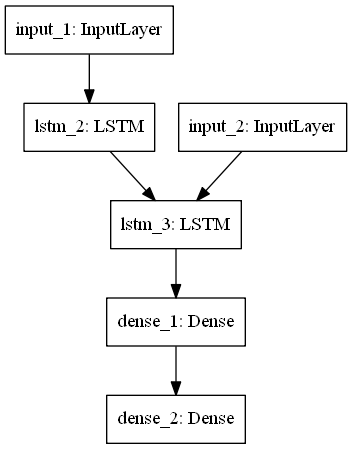

In [10]:
# 基本参数
batch_size = 80
epochs = 25
latent_dim = 72  # LSTM 的单元个数
num_encoder_tokens = Intrain.shape[2]
num_decoder_tokens = Outtrain.shape[2]

# 定义编码器的输入
# encoder_inputs (None, num_encoder_tokens), None表示可以处理任意长度的序列
encoder_inputs = Input(shape=(None, num_encoder_tokens))

# 编码器，要求其返回状态
encoder = LSTM(latent_dim, return_state=True, dropout=0.3)

# 调用编码器，得到编码器的输出，以及状态信息 state_h 和 state_c
encoder_outpus, state_h, state_c = encoder(encoder_inputs)

# 丢弃encoder_outputs, 我们只需要编码器的状态
encoder_state = [state_h, state_c]

# 定义解码器的输入
# None表示可以处理任意长度的序列
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# 接下来建立解码器，解码器将返回整个输出序列并且返回其中间状态
decoder_lstm = LSTM(latent_dim, return_sequences=True, dropout=0.3)

# 将编码器输出的状态作为初始解码器的初始状态
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_state)

# 添加全连接层
decoder_dense1 = Dense(8, activation='relu')
decoder_dense2 = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense2(decoder_dense1(decoder_outputs))

# 定义整个模型
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 定义回调函数
#callback_list = [callbacks.EarlyStopping(patience=10)]
# 编译模型
model1.compile(optimizer='adam',
               loss='mean_absolute_percentage_error')
# print(model1.summary())
plot_model(model1)

In [11]:
Outtrain_ = np.zeros(
    shape=(Outtrain.shape[0], Outtrain.shape[1]+1, Outtrain.shape[2]))
for i in range(Outtrain_.shape[0]):
    a = Outtrain[i][Outtrain.shape[1] - 1]
    Outtrain_[i] = np.concatenate((Outtrain[i], [a]))

In [12]:
# 训练
History1 = model1.fit([Intrain, Outtrain], Outtrain_[:,1:],
                      batch_size=batch_size,
                      epochs=epochs)

Train on 5531 samples
Epoch 1/25
5531/5531 [==============================] - 1s 165us/sample - loss: 58.1068
Epoch 2/25
5531/5531 [==============================] - 1s 170us/sample - loss: 18.9551
Epoch 3/25
5531/5531 [==============================] - 1s 170us/sample - loss: 16.5369
Epoch 4/25
5531/5531 [==============================] - 1s 170us/sample - loss: 15.6527
Epoch 5/25
5531/5531 [==============================] - 1s 169us/sample - loss: 15.3554
Epoch 6/25
5531/5531 [==============================] - 1s 170us/sample - loss: 15.4076
Epoch 7/25
5531/5531 [==============================] - 1s 174us/sample - loss: 15.1091
Epoch 8/25
5531/5531 [==============================] - 1s 173us/sample - loss: 15.2662
Epoch 9/25
5531/5531 [==============================] - 1s 169us/sample - loss: 15.3183
Epoch 10/25
5531/5531 [==============================] - 1s 169us/sample - loss: 15.0149
Epoch 11/25
5531/5531 [==============================] - 1s 173us/sample - loss: 14.8030
Epoch 12

## 注意力模型

In [13]:
# 从softmax、单步注意力、注意力层构建注意力层


# 基本参数:
Tx = Intrain.shape[1]  # 最大输入序列长度
Ty = Outtrain.shape[1]  # 最大输出序列长度
layer1_size = 72
layer2_size = 72  # Attention layer
intoken = Intrain.shape[2] # 序列维度
outtoken = Outtrain.shape[2]

def softmax(x):
    return K.softmax(x, axis=1)


at_repeat = RepeatVector(Tx)
at_concatenate = Concatenate(axis=-1)
at_dense1 = Dense(10, activation="relu")
at_dense2 = Dense(1, activation="relu")
at_softmax = Activation(softmax, name='attention_weights')
at_dot = Dot(axes=1)


def one_step_of_attention(h_prev, a):
    """
    Get the context.

    Input:
    h_prev - 解码器隐藏状态(m, n_h)
    a - 编码器隐藏状态(m, Tx, n_a)

    Output:
    context - 中间向量(m, Tx, n_a)
    """
    # Repeat vector to match a's dimensions
    h_repeat = at_repeat(h_prev)
    # Calculate attention weights
    i = at_concatenate([a, h_repeat])
    i = at_dense1(i)
    i = at_dense2(i)
    attention = at_softmax(i)
    # Calculate the context
    context = at_dot([attention, a])

    return context

In [14]:
def attention_layer(X, n_h, Ty):
    """
    Creates an attention layer.
    
    Input:
    X - Layer input shape(m, Tx, token)
    n_h - Size of LSTM hidden layer
    Ty - Timesteps in output sequence
    
    Output:
    output - The output of the attention layer shape(m, Tx, n_h)
    """    
    # Define the default state for the LSTM layer
    h = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)))(X)
    c = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)))(X)
    # Messy, but the alternative is using more Input()
    
    at_LSTM = LSTM(n_h, return_state=True,dropout=0.3)
    
    output = []
              
    # Run attention step and RNN for each output time step
    for _ in range(Ty):
        context = one_step_of_attention(h, X)
        
        h, _, c = at_LSTM(context, initial_state=[h, c])
        
        output.append(h)
        
    return output

In [15]:
def get_model(Tx, Ty, layer1_size, layer2_size, input_token, output_token):
    """
    Creates a model.
    
    input:
    Tx - Number of x timesteps
    Ty - Number of y timesteps
    size_layer1 - Number of neurons in first LSTM
    size_layer2 - Number of neurons in attention LSTM hidden layer
    token - Number of possible token types
    
    Output:
    model - A Keras Model.
    """
    layer31 = Dense(8, activation='relu')
    layer32 = Dense(5, activation='relu')
    layer33 = Dense(output_token, activation='sigmoid')
    # Create layers one by one
    X = Input(shape=(Tx, input_token))
    
    a1 = Bidirectional(LSTM(layer1_size, return_sequences=True,dropout=0.1), merge_mode='concat')(X)

    a2 = attention_layer(a1, layer2_size, Ty)
    
    a3 = [layer33(layer32(layer31(timestep))) for timestep in a2]
        
    # Create Keras model
    model = Model(inputs=[X], outputs=a3)
    
    return model

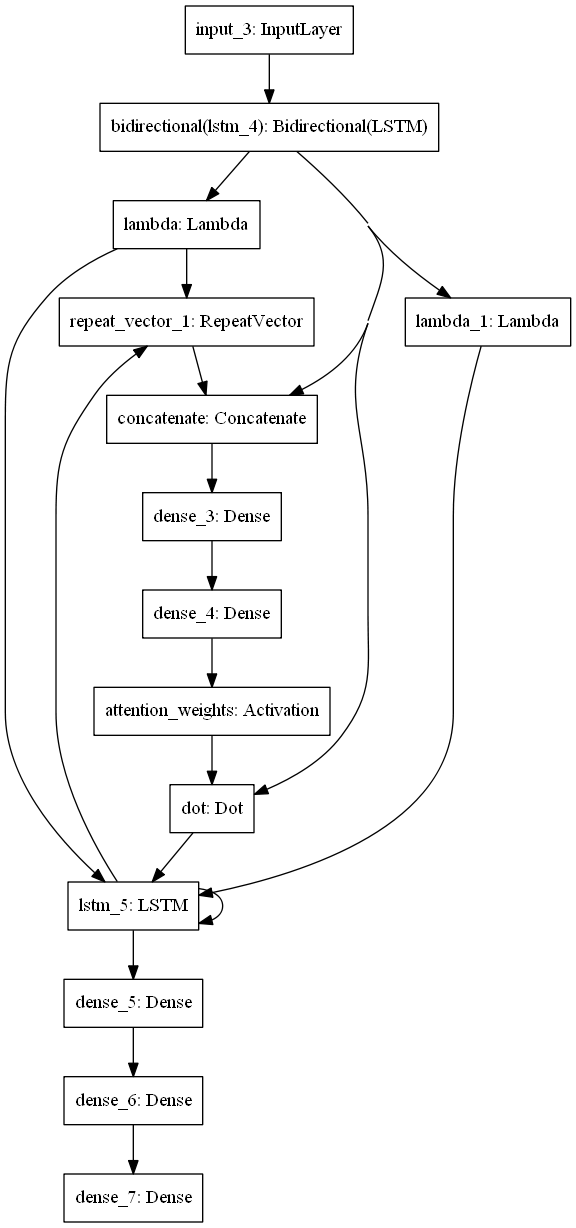

In [16]:
# Obtain a model instance
model3 = get_model(Tx, Ty, layer1_size, layer2_size, intoken, outtoken)

# Create optimizer
model3.compile(optimizer='adam', loss='mean_absolute_percentage_error')

# print(model3.summary())
plot_model(model3)

In [17]:
# Time to train

outputs = list(Outtrain.swapaxes(0, 1))
History3 = model3.fit([Intrain], outputs, epochs=20, batch_size=64)

Train on 5531 samples
Epoch 1/20
5531/5531 [==============================] - 4s 648us/sample - loss: 401.1428 - dense_7_loss: 55.4195 - dense_7_1_loss: 42.6861 - dense_7_2_loss: 38.4748 - dense_7_3_loss: 36.8191 - dense_7_4_loss: 36.5826 - dense_7_5_loss: 36.7221 - dense_7_6_loss: 37.3693 - dense_7_7_loss: 37.9305 - dense_7_8_loss: 38.6329 - dense_7_9_loss: 39.2848
Epoch 2/20
5531/5531 [==============================] - 4s 654us/sample - loss: 204.6200 - dense_7_loss: 23.7771 - dense_7_1_loss: 20.5687 - dense_7_2_loss: 19.3869 - dense_7_3_loss: 19.1724 - dense_7_4_loss: 19.3630 - dense_7_5_loss: 19.5786 - dense_7_6_loss: 19.9353 - dense_7_7_loss: 20.3833 - dense_7_8_loss: 20.9558 - dense_7_9_loss: 21.5036
Epoch 3/20
5531/5531 [==============================] - 4s 655us/sample - loss: 163.6984 - dense_7_loss: 18.0413 - dense_7_1_loss: 15.7410 - dense_7_2_loss: 15.2015 - dense_7_3_loss: 15.4723 - dense_7_4_loss: 15.8229 - dense_7_5_loss: 16.0299 - dense_7_6_loss: 16.2902 - dense_7_7_los

## 行为注意力模型

In [13]:
# 从softmax、单步注意力、注意力层构建注意力层


# 基本参数:
Tx = InLtrain.shape[1]  # 最大输入序列长度
Ty = 1  # 最大输出序列长度
layer1_size = 32
layer2_size = 32  # Attention layer
input_token = InLtrain.shape[2] # 输入序列维度
output_token = OutLtrain.shape[1] #输出序列维度

def softmax1(x):
    return K.softmax(x, axis=1)


at_repeat = RepeatVector(Tx)
at_concatenate = Concatenate(axis=-1)
at_dense1 = Dense(16, activation="relu")
at_dense2 = Dense(1, activation="relu")
at_softmax = Activation(softmax1, name='attention_weights')
at_dot = Dot(axes=1)


def one_step_of_attention1(h_prev, a):
    """
    Get the context.

    Input:
    h_prev - 解码器隐藏状态(m, n_h)
    a - 编码器隐藏状态(m, Tx, n_a)

    Output:
    context - 中间向量(m, Tx, n_a)
    """
    # Repeat vector to match a's dimensions
    h_repeat = at_repeat(h_prev)
    # Calculate attention weights
    i = at_concatenate([a, h_repeat])
    i = at_dense1(i)
    i = at_dense2(i)
    attention = at_softmax(i)
    # Calculate the context
    context = at_dot([attention, a])

    return context

In [14]:
def attention_layer1(X, n_h, Ty):
    """
    Creates an attention layer.
    
    Input:
    X - Layer input shape(m, Tx, token)
    n_h - Size of LSTM hidden layer
    Ty - Timesteps in output sequence
    
    Output:
    output - The output of the attention layer shape(m, Tx, n_h)
    """    
    # Define the default state for the LSTM layer
    h = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)))(X)
    c = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)))(X)
    # Messy, but the alternative is using more Input()
    
    at_LSTM = LSTM(n_h, return_state=True,dropout=0.1)
    
    output = []
              
    # Run attention step and RNN for each output time step
    for _ in range(Ty):
        context = one_step_of_attention1(h, X)
        
        h, _, c = at_LSTM(context, initial_state=[h, c])
        
        output.append(h)
        
    return output

In [15]:
def get_model1(Tx, Ty, layer1_size, layer2_size, input_token, output_token):
    """
    Creates a model.
    
    input:
    Tx - Number of x timesteps
    Ty - Number of y timesteps
    size_layer1 - Number of neurons in first LSTM
    size_layer2 - Number of neurons in attention LSTM hidden layer
    token - Number of possible token types
    
    Output:
    model - A Keras Model.
    """
    layer31 = Dense(8, activation='relu')
#     layer32 = Dense(4, activation='relu')
    layer33 = Dense(output_token, activation='softmax')
    # Create layers one by one
    X = Input(shape=(Tx, input_token))
    
    a1 = LSTM(layer1_size, return_sequences=True,dropout=0.1)(X)

    a2 = attention_layer1(a1, layer2_size, Ty)
    
    a3 = [layer33(layer31(timestep)) for timestep in a2]
        
    # Create Keras model
    model = Model(inputs=[X], outputs=a3)
    
    return model

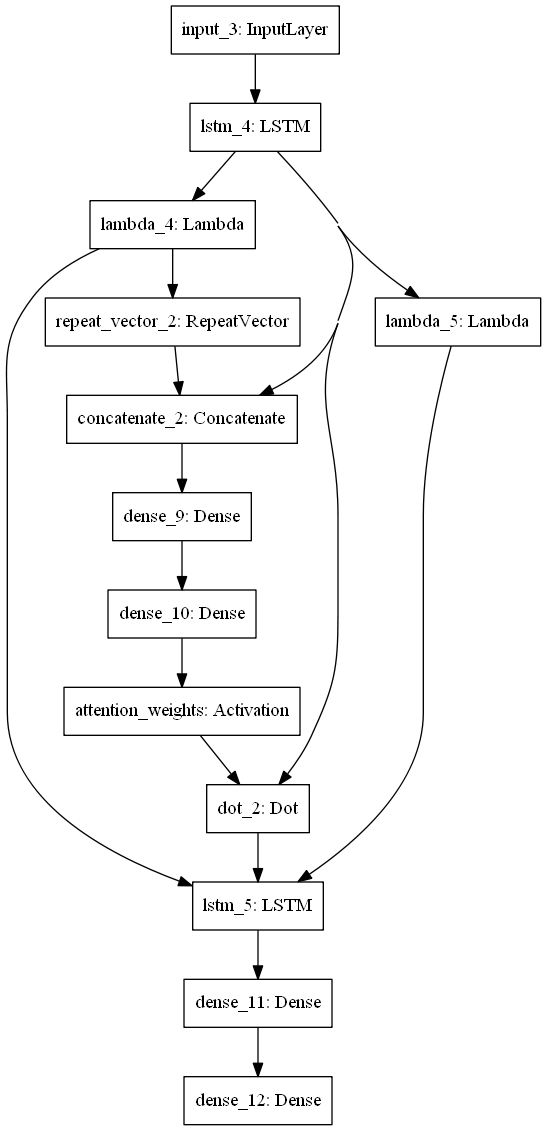

In [16]:
# Obtain a model instance
model4 = get_model1(Tx, Ty, layer1_size, layer2_size, input_token, output_token)

# Create optimizer
model4.compile(optimizer='adam', loss='categorical_crossentropy')

# print(model4.summary())
plot_model(model4)

In [17]:
# Time to train

History4 = model4.fit(InLtrain101, OutLtrain101, epochs=30, batch_size=16)

Train on 2445 samples
Epoch 1/30
2445/2445 [==============================] - 1s 277us/sample - loss: 1.0005
Epoch 2/30
2445/2445 [==============================] - 1s 270us/sample - loss: 0.8988
Epoch 3/30
2445/2445 [==============================] - 1s 273us/sample - loss: 0.8953
Epoch 4/30
2445/2445 [==============================] - 1s 270us/sample - loss: 0.8933
Epoch 5/30
2445/2445 [==============================] - 1s 286us/sample - loss: 0.8931
Epoch 6/30
2445/2445 [==============================] - 1s 271us/sample - loss: 0.8913
Epoch 7/30
2445/2445 [==============================] - 1s 274us/sample - loss: 0.8878
Epoch 8/30
2445/2445 [==============================] - 1s 271us/sample - loss: 0.8842
Epoch 9/30
2445/2445 [==============================] - 1s 272us/sample - loss: 0.8822
Epoch 10/30
2445/2445 [==============================] - 1s 271us/sample - loss: 0.8712
Epoch 11/30
2445/2445 [==============================] - 1s 271us/sample - loss: 0.8769
Epoch 12/30
2445/24

## 行为LSTM

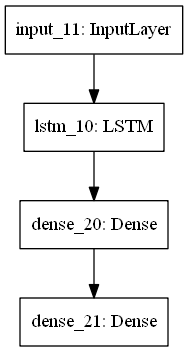

In [39]:
# 基本参数:
Tx = InLtrain.shape[1]  # 最大输入序列长度
layer1_size = 32
input_token = InLtrain.shape[2] # 输入序列维度
output_token = OutLtrain.shape[1] #输出序列维度

def get_model2(Tx, layer1_size, input_token, output_token):
    layer1 = Dense(16, activation='relu')
#     layer2 = Dense(16, activation='relu')
    layer3 = Dense(output_token, activation='softmax')
    # Create layers one by one
    X = Input(shape=(Tx, input_token))
    
    a1 = LSTM(layer1_size, return_sequences=False)(X)
    
    a2 = layer3(layer1(a1))
        
    # Create Keras model
    model = Model(inputs=[X], outputs=a2)
    
    return model

# Obtain a model instance
model5 = get_model2(Tx, layer1_size, input_token, output_token)

# Create optimizer
model5.compile(optimizer='adam', loss='categorical_crossentropy')

plot_model(model5)

In [40]:
# Time to train

History5 = model5.fit(InLtrain101, OutLtrain101, epochs=45, batch_size=16)

Train on 2445 samples
Epoch 1/45
2445/2445 [==============================] - 1s 365us/sample - loss: 0.9153
Epoch 2/45
2445/2445 [==============================] - 1s 370us/sample - loss: 0.8825
Epoch 3/45
2445/2445 [==============================] - 1s 354us/sample - loss: 0.8553
Epoch 4/45
2445/2445 [==============================] - 1s 355us/sample - loss: 0.8029
Epoch 5/45
2445/2445 [==============================] - 1s 356us/sample - loss: 0.6883
Epoch 6/45
2445/2445 [==============================] - 1s 357us/sample - loss: 0.5614
Epoch 7/45
2445/2445 [==============================] - 1s 361us/sample - loss: 0.4629
Epoch 8/45
2445/2445 [==============================] - 1s 352us/sample - loss: 0.4130
Epoch 9/45
2445/2445 [==============================] - 1s 345us/sample - loss: 0.3945
Epoch 10/45
2445/2445 [==============================] - 1s 354us/sample - loss: 0.3688
Epoch 11/45
2445/2445 [==============================] - 1s 353us/sample - loss: 0.3898
Epoch 12/45
2445/24

# 结果

## 双LSTM

In [23]:
pred1 = model.predict(Intest)
pred1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


array([[[0.5366195 , 0.39400908],
        [0.5327156 , 0.43186942],
        [0.5343516 , 0.4622145 ],
        ...,
        [0.53191245, 0.58087915],
        [0.53260034, 0.6023214 ],
        [0.5330792 , 0.6222274 ]],

       [[0.28298366, 0.2780825 ],
        [0.2949589 , 0.2995529 ],
        [0.2962898 , 0.31554538],
        ...,
        [0.29008466, 0.37949458],
        [0.29025418, 0.392136  ],
        [0.29052734, 0.40423414]],

       [[0.2965327 , 0.35302165],
        [0.30338812, 0.38237604],
        [0.30770272, 0.4065484 ],
        ...,
        [0.3045786 , 0.5015362 ],
        [0.3046245 , 0.520086  ],
        [0.30473322, 0.53772426]],

       ...,

       [[0.23635532, 0.33531457],
        [0.23614693, 0.35947588],
        [0.23389973, 0.3840597 ],
        ...,
        [0.22850312, 0.50894487],
        [0.22864525, 0.53275007],
        [0.22878788, 0.5551037 ]],

       [[0.3188795 , 0.3580409 ],
        [0.31955487, 0.3873913 ],
        [0.32164216, 0.4208466 ],
        .

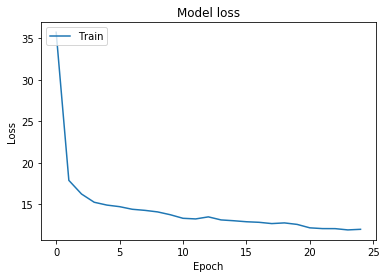

In [24]:
# 绘制训练 & 验证的损失值
plt.plot(History.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [25]:
score=model.evaluate(Intest,Outtest)
print('Loss:',score,'%')

Loss: 8.452676223060132


## 编码解码模型

In [26]:
pred2 = model1.predict([Intest, Outtest])
pred2

array([[[0.4225498 , 0.4170521 ],
        [0.4129502 , 0.44350427],
        [0.40456465, 0.47285715],
        ...,
        [0.3812188 , 0.604936  ],
        [0.3808919 , 0.62952757],
        [0.3818446 , 0.6535393 ]],

       [[0.25466374, 0.31100407],
        [0.24978757, 0.31752157],
        [0.244892  , 0.32321182],
        ...,
        [0.23003282, 0.33898512],
        [0.22993551, 0.34180105],
        [0.23073778, 0.3450514 ]],

       [[0.2619704 , 0.36923644],
        [0.25881964, 0.38299665],
        [0.25508392, 0.39734548],
        ...,
        [0.2437953 , 0.4604497 ],
        [0.24430451, 0.47217068],
        [0.24557203, 0.48401454]],

       ...,

       [[0.22541477, 0.37616104],
        [0.21669258, 0.3916229 ],
        [0.21065834, 0.40710086],
        ...,
        [0.21494834, 0.45576766],
        [0.21897317, 0.4622968 ],
        [0.22271058, 0.46899098]],

       [[0.28721365, 0.4007768 ],
        [0.27054086, 0.42511955],
        [0.25800622, 0.44981605],
        .

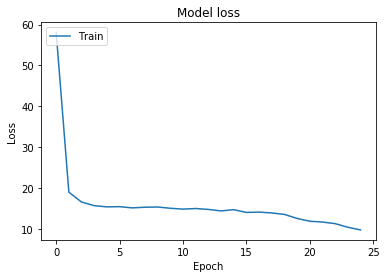

In [27]:
# 绘制训练 & 验证的损失值
plt.plot(History1.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [28]:
Outtest_ = np.zeros(
    shape=(Outtest.shape[0], Outtest.shape[1]+1, Outtest.shape[2]))
for i in range(Outtest_.shape[0]):
    a = Outtest[i][Outtest.shape[1] - 1]
    Outtest_[i] = np.concatenate((Outtest[i], [a]))

In [29]:
score1 = model1.evaluate([Intest,Outtest], Outtest_[:,1:])
print('Loss:', score1,'%')

Loss: 20.102298678676355


## 注意力模型

In [30]:
pred3 = model3.predict(Intest)
pred3 = list((np.array(pred3)).swapaxes(0,1))

pred3

[array([[0.5362606 , 0.4096231 ],
        [0.54622346, 0.42656624],
        [0.54629856, 0.44657424],
        [0.5435435 , 0.47283268],
        [0.53936255, 0.5035152 ],
        [0.5362948 , 0.5370871 ],
        [0.53858125, 0.5687607 ],
        [0.5405416 , 0.5916544 ],
        [0.5420867 , 0.6149029 ],
        [0.543288  , 0.6384327 ]], dtype=float32),
 array([[0.28495052, 0.27899438],
        [0.28910327, 0.28843653],
        [0.28882003, 0.30284983],
        [0.2868179 , 0.31640965],
        [0.28435344, 0.32860094],
        [0.2820668 , 0.33993948],
        [0.27996233, 0.35043073],
        [0.2780357 , 0.360009  ],
        [0.27628395, 0.36862874],
        [0.27470624, 0.3762903 ]], dtype=float32),
 array([[0.3066547 , 0.36070883],
        [0.29844615, 0.3741226 ],
        [0.2953579 , 0.38955557],
        [0.29518595, 0.40750983],
        [0.29342207, 0.42590418],
        [0.2939828 , 0.449942  ],
        [0.29827195, 0.48058152],
        [0.30214968, 0.5095076 ],
        [0.305

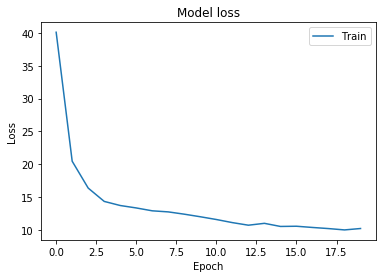

In [31]:
# 绘制训练 & 验证的损失值

plt.plot((np.array(History3.history['loss'])/Outtest.shape[1]))

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [32]:
#Evaluate the test performance
outputs_test = list(Outtest.swapaxes(0,1))

score3 = model3.evaluate(Intest, outputs_test)
av_score=score3[0]/Outtest.shape[1]
print('Test loss: ', av_score,'%')

Test loss:  7.907846137524456


## 行为注意力模型

In [19]:
pred4 = model4.predict(InLtest)
print(OutLtest101)
print(pred4)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
[[0.09274708 0.6210741  0.2861788 ]
 [0.09527972 0.6539981  0.2507222 ]
 [0.0796011  0.6314107  0.28898817]
 ...
 [0.04218056 0.3284391  0.62938035]
 [0.03066762 0.2370102  0.73232216]
 [0.06797627 0.46105582 0.47096795]]


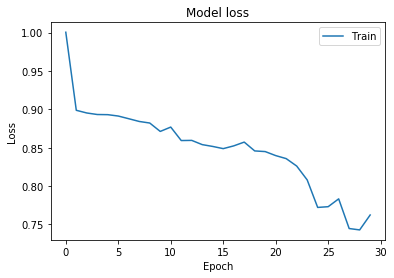

In [20]:
# 绘制训练 & 验证的损失值

plt.plot((np.array(History4.history['loss'])))

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [22]:
#Evaluate the test performance

# outputs_test = list(Outtest.swapaxes(0,1))

score4 = model4.evaluate(InLtest, OutLtest)
print('Test loss: ', score4)

Test loss:  0.8585501107156377


## 行为LSTM

In [ ]:
pred5 = model5.predict(InLtest)
print(pred5)
print(OutLtest)
# 绘制训练 & 验证的损失值

plt.plot((np.array(History5.history['loss'])))

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

#Evaluate the test performance

# outputs_test = list(Outtest.swapaxes(0,1))

score5 = model5.evaluate(InLtest101, OutLtest101)
print('Test loss: ', score5)

# 可视化 

## 多模态可视化

In [36]:
test1 = np.array([[[0.44127927, 0.12550959, 0, 1, 0],
                   [0.43642325, 0.15602006, 0, 1, 0],
                   [0.4318456,  0.18711935, 0, 1, 0],
                   [0.42950522, 0.22080312, 0, 1, 0],
                   [0.42532966, 0.25368458, 0, 1, 0],
                   [0.42419556, 0.28986295, 0, 1, 0],
                   [0.42240162, 0.31350992, 0, 1, 0],
                   [0.42249441, 0.34439795, 0, 1, 0],
                   [0.42206139, 0.3749264,  0, 1, 0],
                   [0.41956636, 0.40415361, 0, 1, 0]]])
test2 = np.array([[[0.44127927, 0.12550959, 1, 0, 0],
                   [0.43642325, 0.15602006, 1, 0, 0],
                   [0.4318456,  0.18711935, 1, 0, 0],
                   [0.42950522, 0.22080312, 1, 0, 0],
                   [0.42532966, 0.25368458, 1, 0, 0],
                   [0.42419556, 0.28986295, 1, 0, 0],
                   [0.42240162, 0.31350992, 1, 0, 0],
                   [0.42249441, 0.34439795, 1, 0, 0],
                   [0.42206139, 0.3749264,  1, 0, 0],
                   [0.41956636, 0.40415361, 1, 0, 0]]])
test3 = np.array([[[0.44127927, 0.12550959, 0, 0, 1],
                   [0.43642325, 0.15602006, 0, 0, 1],
                   [0.4318456,  0.18711935, 0, 0, 1],
                   [0.42950522, 0.22080312, 0, 0, 1],
                   [0.42532966, 0.25368458, 0, 0, 1],
                   [0.42419556, 0.28986295, 0, 0, 1],
                   [0.42240162, 0.31350992, 0, 0, 1],
                   [0.42249441, 0.34439795, 0, 0, 1],
                   [0.42206139, 0.3749264,  0, 0, 1],
                   [0.41956636, 0.40415361, 0, 0, 1]]])
outtest = np.array([[[0.41548359, 0.43209757],
                     [0.40525605, 0.45497818],
                     [0.38932706, 0.47572602],
                     [0.37337746, 0.50590612],
                     [0.35796398, 0.53656043],
                     [0.34254018, 0.56705741],
                     [0.32660089, 0.5986264],
                     [0.31043477, 0.62968298],
                     [0.29975359, 0.65322657],
                     [0.29971235, 0.66751992]]])
pred31 = model3.predict(test1)
pred32 = model3.predict(test2)
pred33 = model3.predict(test3)
pred31 = (np.array(pred31)).swapaxes(0,1)
pred32 = (np.array(pred32)).swapaxes(0,1)
pred33 = (np.array(pred33)).swapaxes(0,1)
# print(Outtest[0])

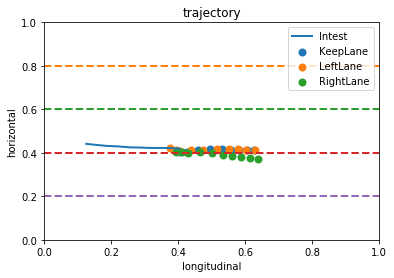

In [38]:
i = 0

# apred1 = pred1[i].swapaxes(0, 1)
# apred2 = pred2[i].swapaxes(0, 1)
apred31 = pred31[0].swapaxes(0, 1)
apred32 = pred32[0].swapaxes(0, 1)
apred33 = pred33[0].swapaxes(0, 1)

aIntest = test1[0].swapaxes(0, 1)
# aOuttest = Outtest[i].swapaxes(0, 1)
# print(aIntest, '\n\n\n', aOuttest)

# plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
# plt.scatter(apred1[1], apred1[0], lw=2, label="Model1")
# plt.scatter(apred2[1], apred2[0], lw=2, label="Model2")
plt.scatter(apred31[1], apred31[0], lw=2, label="KeepLane")
plt.scatter(apred32[1], apred32[0], lw=2, label="LeftLane")
plt.scatter(apred33[1], apred33[0], lw=2, label="RightLane")
plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('trajectory')
plt.ylabel('horizontal')
plt.xlabel('longitudinal')
plt.legend()
plt.show()

## 模型对比可视化

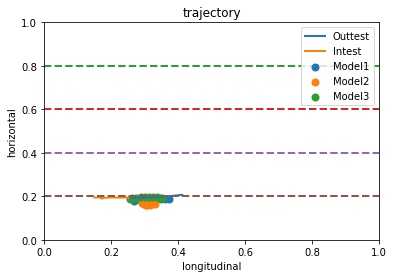

In [39]:
i = 17
# print(OutLtest[4])
apred1 = pred1[i].swapaxes(0, 1)
apred2 = pred2[i].swapaxes(0, 1)
apred3 = pred3[i].swapaxes(0, 1)

aIntest = Intest[i].swapaxes(0, 1)
aOuttest = Outtest[i].swapaxes(0, 1)
# print(aIntest)
# print(aOuttest)

plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
plt.scatter(apred1[1], apred1[0], lw=2, label="Model1")
plt.scatter(apred2[1], apred2[0], lw=2, label="Model2")
plt.scatter(apred3[1], apred3[0], lw=2, label="Model3")
plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('trajectory')
plt.ylabel('horizontal')
plt.xlabel('longitudinal')
plt.legend()
plt.show()